In [1]:
import pysam
import main.functions as fnc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic, linregress
from maxentpy.maxent import load_matrix5, load_matrix3, score5, score3
from collections import defaultdict

In [2]:
bamFile = "./ref/ENCFF950KXS.bam"
genomeFile = "./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz"

genome = fnc.openGenomeFile(genomeFile)

In [3]:
def getSpliceCoordsAndCounts(bamFile, genome):

    bam = pysam.AlignmentFile(bamFile, "rb")

    fivePrimeSites = defaultdict(int)
    threePrimeSites = defaultdict(int)

    numIntronsPerCigar = defaultdict(int)
    lenIntrons = defaultdict(int)

    pysamIntrons = bam.find_introns(bam.fetch())
    manualIntrons = []

    # go through each read in the bam file and 
    for read in bam.fetch(): # make it easier to run by only doing the 14th chromosome (short one)
        
        if read.cigar is None: # make sure read has a cigar string
            continue

        # Get the reads reference name (chrom) and strand info
        chrom = bam.get_reference_name(read.reference_id).strip("chr") # get rid of "chr" because genome file just uses number

        if "ERCC" in chrom:
            continue

        elif "random" in chrom or "Un" in chrom:
            rawChr = chrom.split('_')[1]
            vIndx = rawChr.rfind('v')
            chrom = rawChr[:vIndx] + '.' + rawChr[vIndx + 1:] # BAM file chromosome format e.g "22_KI270733v1_random" and genome uses "KI270733.1" so manipulate string for correct format

        elif chrom == "M": # genome file uses "MT" for mitochondrial seq
            chrom = "MT"

        strand = '-' if read.is_reverse else '+'

        # start the the reference position at the reference start
        refPos = read.reference_start
        
        if list(np.array(read.cigartuples)[:, 0]).count(3) >= 2:
            numIntronsPerCigar[read.cigarstring] += 1

        # go through the cigar string to find splice sites
        for operation, length in read.cigartuples:
            
            if operation == 3:  # cigar == 3 corresponds to the 'N' operation which is intronic aka the only thing we're interest in

                intronStart = refPos
                intronEnd = refPos + length

                manualIntrons.append((intronStart, intronEnd))

                lenIntrons[(chrom, intronStart, intronEnd, strand)] = length

                # determine the splice site coordinates
                if strand == "+":
                    #if intronStart >= 3 and intronEnd < len(genome[chrom]) - 3: # check if enough upstream/downstream nucleotides
                    threePrimeSites[(chrom, intronEnd - 20, intronEnd + 3, strand)] += 1
                    fivePrimeSites[(chrom, intronStart - 3, intronStart + 6, strand)] += 1
                
                elif strand == "-":
                    #if intronStart >= 3 and intronEnd < len(genome[chrom]) - 3: # check if enough upstream/downstream nucleotides
                    threePrimeSites[(chrom, intronStart - 3, intronStart + 20, strand)] += 1
                    fivePrimeSites[(chrom, intronEnd - 6, intronEnd + 3, strand)] += 1
                    
            # update the reference position based on the cigar operation
            if operation in {0, 2, 3, 7, 8}:  # these operations consume reference bases (searched this up)
                refPos += length
        
    bam.close()

    return fivePrimeSites, threePrimeSites, numIntronsPerCigar, lenIntrons, pysamIntrons, manualIntrons

fivePrimeSites, threePrimeSites, numIntronsPerCigar, lenIntrons, pysamIntrons, manualIntrons = getSpliceCoordsAndCounts(bamFile, genome)

ERROR!!! Introns found with pysam are NOT the same as the introns found manually -> there IS a problem with the reference position

387038 unique 5' sites found in BAM file
383237 unique 3' sites found in BAM file

there are 1735807 cigar strings with more than one intron
the first 5 look like this: ['38M757N16M13509N22M', '14M206N42M11293N20M', '16M56921N59M2157N1M', '15M93N58M227N3M', '11M93N58M227N7M']

all chromosomes in BAM file: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'GL000008.2', 'GL000009.2', 'GL000194.1', 'GL000195.1', 'GL000205.2', 'GL000213.1', 'GL000214.1', 'GL000216.2', 'GL000218.1', 'GL000219.1', 'GL000220.1', 'GL000221.1', 'GL000224.1', 'GL000225.1', 'KI270303.1', 'KI270322.1', 'KI270442.1', 'KI270466.1', 'KI270467.1', 'KI270579.1', 'KI270706.1', 'KI270707.1', 'KI270708.1', 'KI270709.1', 'KI270711.1', 'KI270712.1', 'KI270713.1', 'KI270718.1', 'KI270719.1', 'KI270720.1', 'KI270721.1', 'KI

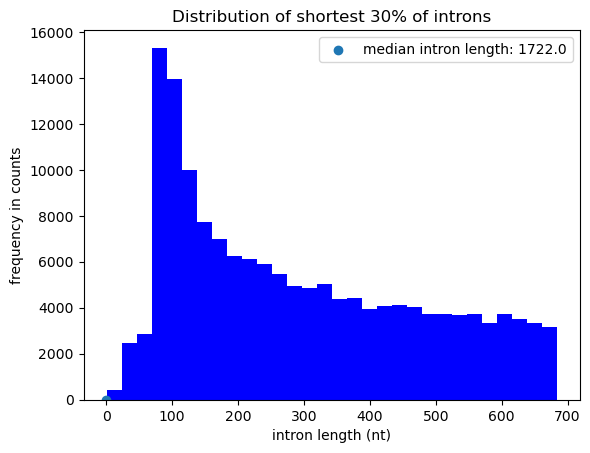

(<matplotlib.legend.Legend at 0x5a9bc0fb0>, None)

In [4]:
if sorted(list(pysamIntrons.keys())) == sorted(set(manualIntrons)):
    print("Introns found with pysam are the same as the introns found manually -> there is no problem with the reference position")
else:
    print("ERROR!!! Introns found with pysam are NOT the same as the introns found manually -> there IS a problem with the reference position")
print()

fiveSites = list(fivePrimeSites.keys())
threeSites = list(threePrimeSites.keys())
print(f"{len(fiveSites)} unique 5\' sites found in BAM file")
print(f"{len(threeSites)} unique 3\' sites found in BAM file")
print()

print(f"there are {sum(list(numIntronsPerCigar.values()))} cigar strings with more than one intron")
print(f"the first 5 look like this: {list(numIntronsPerCigar)[:5]}")
print()

print(f"all chromosomes in BAM file: {sorted(set(np.array(fiveSites)[:,0]))}")
print()

annotationFile = "./ref/Homo_sapiens.GRCh38.112.chr.gtf.gz"
transcriptExons = fnc.getExonData(annotationFile)
sites5, sites3 = fnc.getSpliceSites(transcriptExons, genome)

print(f"{len(sites5)} unique 5\' splice sites were found in the GTF file")
print(f"{len(sites3)} unique 3\' splice sites were found in the GTF file")
print()

count5 = 0
count3 = 0
keptSites5 = {}
keptSites3 = {}
for site in fiveSites:
    if site in sites5:
        keptSites5[site] = fivePrimeSites[site]
        count5 += 1
for site in threeSites:
    if site in sites3:
        keptSites3[site] = threePrimeSites[site]
        count3 += 1


print(f"{(100 * count5 / len(fiveSites)):.3f}% of rna-seq five prime sites are recognized in the GTF file")
print(f"{(100 * count3 / len(threeSites)):.3f}% of rna-seq three prime sites are recognized in the GTF file")
print()

print(f"30 shortest introns: {sorted(list(lenIntrons.values()))[:30]}")

plt.hist(sorted(list(lenIntrons.values()))[:int(len(list(lenIntrons.values())) * 0.3)], bins = 30, color='blue')
plt.scatter([0],[0], label = f"median intron length: {np.median(list(lenIntrons.values()))}")
plt.xlabel("intron length (nt)"), plt.ylabel("frequency in counts")
plt.title("Distribution of shortest 30% of introns")
plt.legend(), plt.show()

In [20]:
fivePrimeSequences = fnc.extractSequences(list(keptSites5.keys()), genome)
threePrimeSequences = fnc.extractSequences(list(keptSites3.keys()), genome)

In [21]:
# get lists with genome sequences from splice site coordinates
fivePrimeSequences = fnc.extractSequences(list(fivePrimeSites.keys()), genome)
threePrimeSequences = fnc.extractSequences(list(threePrimeSites.keys()), genome)

In [22]:
# use slow version of maxentpy to get strength scores for the splice site sequences
matrix5 = load_matrix5()
matrix3 = load_matrix3()

skipIndx5 = []
fivePrimeStrengths = []
for i, seq5 in enumerate(fivePrimeSequences):
    if "N" in seq5:
        skipIndx5.append(i)
        continue 
    fivePrimeStrengths.append(score5(seq5, matrix5))
print()

skipIndx3 = []
threePrimeStrengths = []
for i, seq3 in enumerate(threePrimeSequences):
    if "N" in seq3:
        skipIndx3.append(i)
        continue
    score = score3(seq3, matrix3)

    if -20 < score < -10:
        print(seq3)
    
    threePrimeStrengths.append(score)


AAGCTCCAGGGCCCGCTCACCTT
CCTCAAAGAGCTGCTCCCACCTG
AAGAAGGGGTCTAATAACAAACT
AGGGAGCCTGAACAAGTGAGGCT
CCAGAACCCAGCTCACCTACCTT
CATCCCAGAACCCAGCTCACCTA
CCAGAACCCAGCTCACCTACCTT
TATATGCGCGGCCAGCAGACCTG
CACAGGGGTATGGGGACTACCTT
GGGTGAGTGGCAGCACCCACCTG
GTGGGGGTGAGTGGCAGCACCCA
CTGAAGTCAGGGTCACCTACTTG
CAGGATCTCCCAGCAGGTAGAGC
GGGTGAGTGGCAGCACCCACCTG
AGCAAGGCCGCTCTCACTGCAAA
GACAGAAGAGTTTGGGGAAGGTT
GAGCCCAAGGACTGTGCGAGGTC
GGCCTGGGCACGGAACTCACGCT
GGCCTGGGCACGGAACTCACGCT
TGCTGGCATAGTGGTCTCACCTC
aaattaagcatgttgctcacctt
ccccaaaagtcttaactcacttc
ccccaaaagtcttaactcacttc
ttgaaatgattgagactcacctt
ttgaaatgattgagactcacctt
cggcccccatctcctctgacctc
ctccccccaggaagcagcaggtt
cttcctccaggaagcagcaggtt
CAATTTCAGCTCAGATTTACCTT
CAATTTCAGCTCAGATTTACCTT
TGACTTGACTGAAGACGTACCTG
CTTTTCCAGTTTAGACATACCAT
TGACTTGACTGAAGACGTACCTG
GGAACCTGGTAAAAGCTCACCTC
AGGCCCAAGTCCCTGCCTACCTC
TCTACAAACGCAGGCGGGAGCTG
cccctcccacgctgagagaggtc
cccctcccacgctgagagaggtc
cccctcccacgctgagagaggtc
cccctcccacgctgagagaggtc
aaaataattatggaactcaccat
tctgggaaacatggc

In [17]:
fivePrimeCounts = list(keptSites5.values())
threePrimeCounts = list(keptSites3.values())

In [23]:
# convert everything to numpy arrays so its easier to plot
fivePrimeCounts = list(fivePrimeSites.values())
threePrimeCounts = list(threePrimeSites.values())

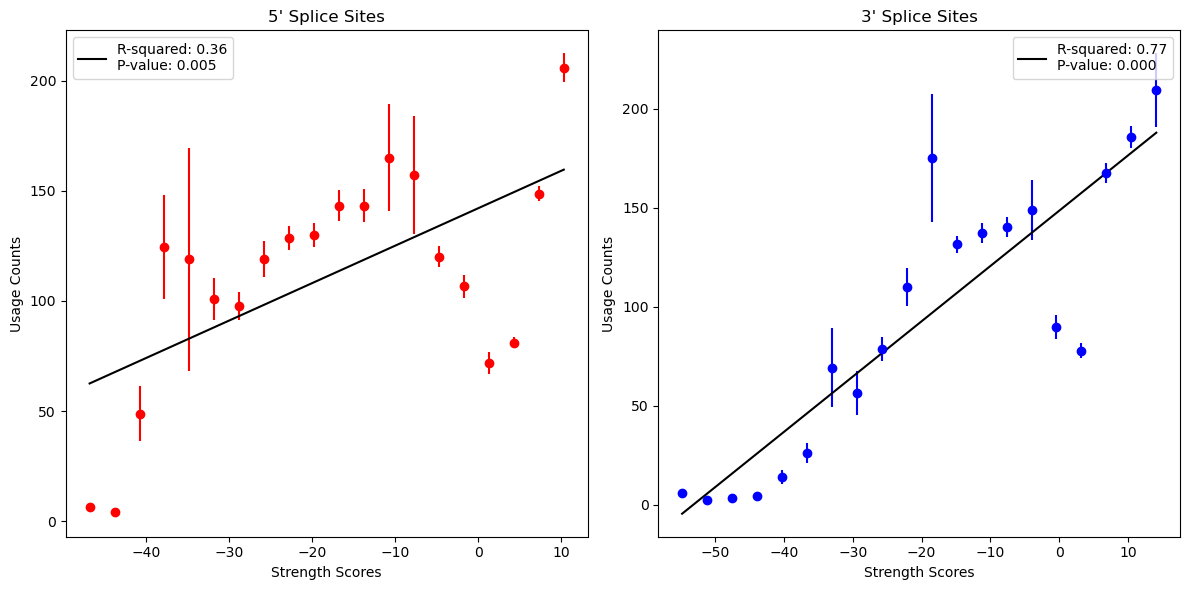

In [24]:

# ensure that any removed sequences due to an 'N' being in it also get their counts removed so x and y are the same length lists
for i in skipIndx5:
    del fivePrimeCounts[i]
for i in skipIndx3:
    del threePrimeCounts[i]

def plotBinnedData(x, y, numBins, ax, colr, title):
    
    x = np.array(x)
    y = np.array(y)

    # calculate bin edges and bin centers
    binEdges = np.linspace(np.min(x), np.max(x), numBins + 1) # create equally dispersed bins on the x axis
    binCenters = (binEdges[:-1] + binEdges[1:]) / 2 # take the averages of the starting and ending edge of each bin

    # get y-value (mean) for each bin
    yMean, _, _ = binned_statistic(x, y, statistic = 'mean', bins = binEdges)
    # calculate stats for error bars
    yStd, _, _ = binned_statistic(x, y, statistic = 'std', bins = binEdges)
    yCount, _, _ = binned_statistic(x, y, statistic = 'count', bins = binEdges)
    yError = yStd / np.sqrt(yCount)

    # do linear regression to get a line of best fit, R value, and P value
    slope, intercept, rValue, pValue, _ = linregress(binCenters, yMean)
    line = slope * binCenters + intercept

    # plot everything
    ax.errorbar(binCenters, yMean, yerr = yError, fmt = 'o', color = colr)
    ax.plot(binCenters, line, color = 'black', linestyle = '-', label = f'R-squared: {rValue**2:.2f}\nP-value: {pValue:.3f}')
    ax.set_title(f"{title}")
    ax.set_xlabel('Strength Scores')
    ax.set_ylabel('Usage Counts')
    ax.legend()
    
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plotBinnedData(fivePrimeStrengths, fivePrimeCounts, numBins = 20, ax = axs[0], colr = "red", title = "5\' Splice Sites")
plotBinnedData(threePrimeStrengths, threePrimeCounts, numBins = 20, ax = axs[1], colr = "blue", title = "3\' Splice Sites")

plt.tight_layout()
plt.savefig("./plots/Splice Site Strength Scores vs Usage Counts")

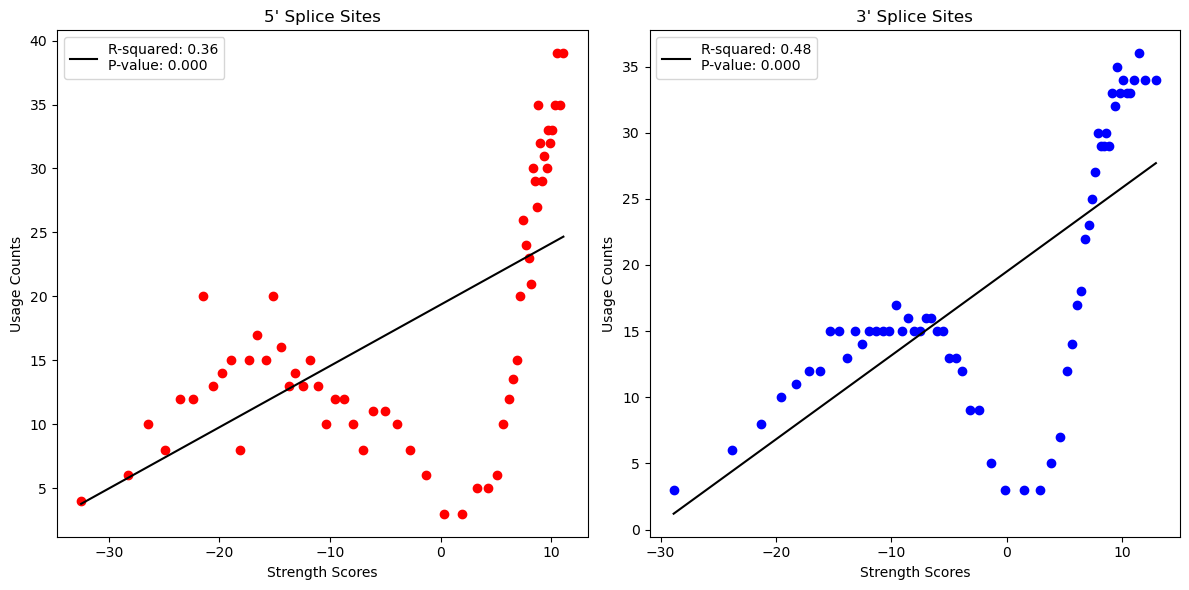

In [25]:
def getBinnedData(x, y, numBins):
    # Combine x and y into a single array and sort by x
    data = np.array(list(zip(x, y)))
    dataSorted = data[np.argsort(data[:, 0])]
    
    # Determine the number of data points per bin
    numPointsPerBin = len(x) // numBins
    
    binnedX = []
    binnedY = []
    
    for i in range(numBins):
        # determine start and end indices for this bin
        startIndex = i * numPointsPerBin
        endIndex = startIndex + numPointsPerBin
        
        # get the data for this bin
        binData = dataSorted[startIndex : endIndex]
        binnedX.append(np.median(binData[:, 0]))  # go through each coordinate ":" and get first value "0" of each (x value)
        binnedY.append(np.median(binData[:, 1]))  # go through each coordinate ":" and get second value "1" of each (y value)
    
    return np.array(binnedX), np.array(binnedY)

binnedX5, binnedY5 = getBinnedData(fivePrimeStrengths, fivePrimeCounts, numBins = 60)
binnedX3, binnedY3 = getBinnedData(threePrimeStrengths, threePrimeCounts, numBins = 60)

def plotWithLine(x, y, ax, clr, title):

    # do linear regression to get a line of best fit, R value, and P value
    slope, intercept, rValue, pValue, _ = linregress(x, y)
    line = slope * x + intercept

    ax.scatter(x, y, color = clr)
    ax.plot(x, line, color = 'black', linestyle = '-', label = f'R-squared: {rValue**2:.2f}\nP-value: {pValue:.3f}')
    ax.set_title(f"{title}")
    ax.set_xlabel('Strength Scores')
    ax.set_ylabel('Usage Counts')
    ax.legend()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plotWithLine(binnedX5, binnedY5, axs[0], "red", "5\' Splice Sites")
plotWithLine(binnedX3, binnedY3, axs[1], "blue", "3\' Splice Sites")

plt.tight_layout()
plt.show()


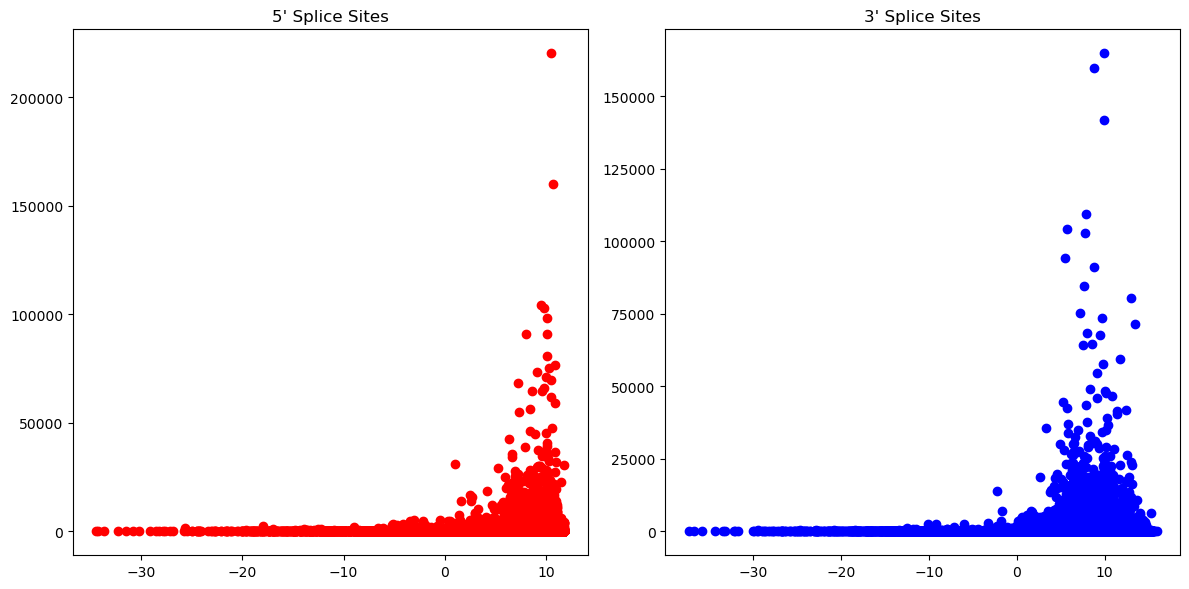

In [255]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

axs[0].scatter(fivePrimeStrengths, fivePrimeCounts, color = "red")
axs[0].set_title("5\' Splice Sites")
axs[1].scatter(threePrimeStrengths, threePrimeCounts, color = "blue")
axs[1].set_title("3\' Splice Sites")

plt.tight_layout()
plt.show()